================================================================================
### Prepare tokenized dataset for BERT / RoBERTa fine-tuning
================================================================================

In [17]:
#Libraries
import os
import re
import random
import numpy as np
import pandas as pd
import torch

from datasets import Dataset
from transformers import AutoTokenizer
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns


# Seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# path
path = "C:/Users/diego/Desktop/Master Neuro/M2/Intership_NLP/multimodal-argmining"
os.chdir(path)



# Model
MODEL_NAME = "roberta-base" 

In [18]:

# Load Dataset
train_path = f"{path}/data/train.csv"
dev_path   = f"{path}/data/dev.csv"
test_path  = f"{path}/data/test.csv"

df_train = pd.read_csv(train_path)
df_dev   = pd.read_csv(dev_path)
df_test  = pd.read_csv(test_path)


print(f"Train dataset loaded: {df_train.shape}")
print(f"Dev dataset loaded: {df_dev.shape}")
print(f"Test dataset loaded: {df_test.shape}")

Train dataset loaded: (1814, 6)
Dev dataset loaded: (200, 6)
Test dataset loaded: (300, 6)


In [ ]:
#Label Mapping & Minimal Text Cleaning

# Mapping
label2id = {"oppose": 0, "support": 1}

# We apply only minimal preprocessing
# Heavy cleaning like stemming or stopword removal is not adviced before tokenization.

def minimal_clean(text):
    text = str(text)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)                      
    text = re.sub(r"\s+", " ", text).strip()              
    return text


for df in [df_train, df_dev, df_test]:
    df["tweet_text"] = df["tweet_text"].apply(minimal_clean)
    df["label"] = df["stance"].map(label2id)

df_train.head()

,tweet_id,tweet_url,tweet_text,stance,persuasiveness,split,label
0,1148501065308004357,https://t.co/VQP1FHaWAg,Let's McGyver some Sanity in America! You are ...,support,no,train,1
1,1103872992537276417,https://t.co/zsyXYSeBkp,A child deserves a chance at life. A child des...,oppose,no,train,0
2,1151528583623585794,https://t.co/qSWvDX5MnM,"Dear prolifers: girls as young as 10, 11, 12 a...",support,no,train,1
3,1100166844026109953,https://t.co/hxH8tFIHUu,The many States will attempt to amend their co...,support,no,train,1
4,1021830413550067713,https://t.co/5whvEEtoQR,"Every #abortion is wrong, no matter what metho...",oppose,yes,train,0


In [20]:
# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
print(f"Tokenizer loaded: {MODEL_NAME}")

Tokenizer loaded: roberta-base


C:\Users\diego\AppData\Local\Temp\ipykernel_30728\3089456599.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


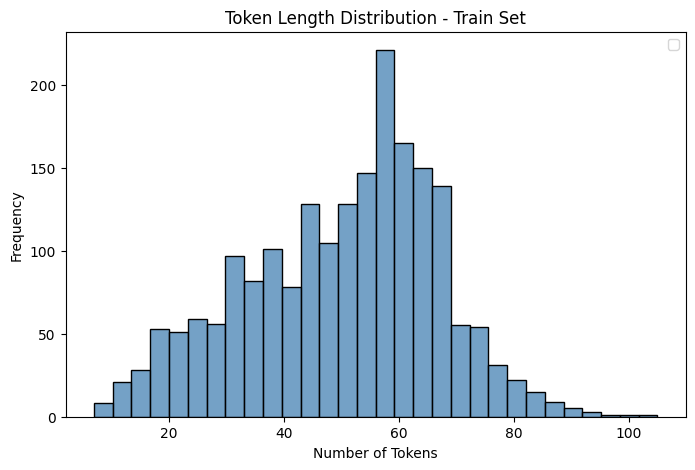

105


In [21]:
# Tokenization

def token_len(text):
    return len(tokenizer.encode(text, add_special_tokens=True))

token_lens = [token_len(t) for t in (df_dev["tweet_text"].to_list()+df_train["tweet_text"].tolist())]


# Plot token length distribution
plt.figure(figsize=(8,5))
sns.histplot(token_lens, bins=30, kde=False, color="steelblue")
plt.title("Token Length Distribution - Train Set")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.legend()
plt.show()

#max_length 
MAX_LEN = np.max(token_lens)
print(MAX_LEN)

In [22]:

# Tokenization Function for each model
def tokenize_dataset(dataset, tokenizer, max_length=MAX_LEN):

    def tokenize_batch(batch):
        return tokenizer(batch["tweet_text"],padding="max_length",truncation=True,max_length=max_length)

    #Tokenization
    tokenized = dataset.map(tokenize_batch, batched=True)

    #Dataset Format for PyTorch
    tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

    return tokenized

# DataFrame to HF Dataset

dataset_train = Dataset.from_pandas(df_train[["tweet_text", "label"]])
dataset_dev   = Dataset.from_pandas(df_dev[["tweet_text", "label"]])
dataset_test  = Dataset.from_pandas(df_test[["tweet_text", "label"]])


# Tokenization for HF Dataset


# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"Tokenizer loaded for {MODEL_NAME}...")

# Tokenize datasets with model tokenizer
train_dataset_tok = tokenize_dataset(dataset_train, tokenizer, MAX_LEN)
dev_dataset_tok = tokenize_dataset(dataset_dev, tokenizer, MAX_LEN)
test_dataset_tok = tokenize_dataset(dataset_test, tokenizer, MAX_LEN)


print(f"Tokenization complete")


Tokenizer loaded for roberta-base...


Map: 100%|██████████| 300/300 [00:00<00:00, 4134.34 examples/s]

Tokenization complete


In [23]:

#Save Tokenized Datasets and Tokenizer
tokenized_dir = f"{path}/tokenized/text/{MODEL_NAME.replace('/', '_')}_maxlen{MAX_LEN}"
os.makedirs(tokenized_dir, exist_ok=True)
train_dataset_tok.save_to_disk(os.path.join(tokenized_dir, "train"))
dev_dataset_tok.save_to_disk(os.path.join(tokenized_dir, "dev"))
test_dataset_tok.save_to_disk(os.path.join(tokenized_dir, "test"))
tokenizer.save_pretrained(tokenized_dir)
print(f"Tokenized datasets and tokenizer saved to:\n{tokenized_dir}")

Saving the dataset (1/1 shards): 100%|██████████| 300/300 [00:00<00:00, 18341.64 examples/s]


Tokenized datasets and tokenizer saved to:
C:/Users/diego/Desktop/Master Neuro/M2/Intership_NLP/multimodal-argmining/tokenized/text/roberta-base_maxlen105


In [24]:
print("Preprocessing and tokenization completed successfully.")

Preprocessing and tokenization completed successfully.
